# Parameter Selection for NMF

Now we look at the more advanced task of parameter selection for NMF topic modelling - namely, selecting a useful value for the number of topics *k*.

First, let's load the TF-IDF normalised document-term matrix and list of terms that we stored earlier using *Joblib*:

In [1]:
import joblib

(A, terms, snippets) = joblib.load("cenario1-tweets-tfidf.pkl")

print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 124203 X 5227 document-term matrix


### Create the Topic Models

A common approach for parameter selection is to Measure and compare the topic coherence of models generated for different values of *k*.

We need to start by pre-specifying an initial range of "sensible" values:

In [2]:
kmin, kmax = 5, 20

Apply NMF for each of these values:

In [3]:
from sklearn import decomposition

topic_models = []

# try each value of k
for k in range(kmin, kmax + 1, 5):
    print("Applying NMF for k=%d ..." % k)
    # run NMF
    model = decomposition.NMF(init="nndsvd", n_components=k)
    W = model.fit_transform(A)
    H = model.components_
    # store for later
    topic_models.append((k, W, H))

Applying NMF for k=5 ...
Applying NMF for k=10 ...
Applying NMF for k=15 ...
Applying NMF for k=20 ...


### Build a Word Embedding

To select the number of topics, here we will use a *topic coherence* measure called TC-W2V. This measure relies on the use of a *word embedding* model constructed from our corpus. So in this step we will use the *Gensim* implementation of Word2Vec to build a Word2Vec model based on our collection of news articles.

**Note:** If you want to skip this step, a pre-built Word2Vec model for the sample dataset [is also provided here for download](http://erdos.ucd.ie/files/pydata/w2v-model.bin) (71MB).

We read the documents from the input file again:

In [4]:
import os.path

raw_documents = []

with open(os.path.join("../../././../../../data-pre-processing/2csv/cenario1_8M2021_tweets_pt.txt"), "r") as fin:
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())

print("Read %d raw text documents" % len(raw_documents))

Read 124203 raw text documents


Read the custom stopword list:

In [5]:
custom_stop_words = []

with open("portuguese.txt", "r") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())

# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 231 entries


First, we need to define a class that will generate documents in a form that can be consumed by Gensim's Word2Vec implementation:

In [6]:
import re


class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile(r"(?u)\b\w\w+\b")

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall(doc):
                if tok in self.stopwords:
                    tokens.append("<stopword>")
                elif len(tok) >= 2:
                    tokens.append(tok)
            yield tokens

Now build a Skipgram Word2Vec model from all documents in the input file using *Gensim*:

In [7]:
import gensim

In [8]:
docgen = TokenGenerator(raw_documents, custom_stop_words)

# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, size=500, min_count=20, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [9]:
print( "Model has %d terms" % len(w2v_model.wv.vocab) )

Model has 5297 terms


Save for later use, so that we do not need to rebuild it:

In [10]:
w2v_model.save("cenario1_w2v-model.bin")

In [11]:
# To re-load this model, run
# w2v_model = gensim.models.Word2Vec.load("cenario1_w2v-model.bin")

### Selecting the Number of Topics

Once we have our Word2vec model, we can use it as part of our *topic coherence* approach to evaluate the different NMF topic models that we created previously. To do this, we will implement a simple version of the TC-W2V coherence measure.

We use the Word2vec model to calculate coherence scores for each of these models. We will define this coherence score as follows:

In [12]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations(term_rankings[topic_index], 2):
            pair_scores.append(w2v_model.similarity(pair[0], pair[1]))
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

We also define a function to get the topic descriptor (i.e. list of top terms) for each topic:

In [13]:
import numpy as np


def get_descriptor(all_terms, H, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort(H[topic_index, :])[::-1]
    
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    
    for term_index in top_indices[0:top]:
        top_terms.append(all_terms[term_index])
    
    return top_terms

Now process each of the models for different values of *k*:

# 5

In [14]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 5))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.5130
K=10: Coherence=0.5044
K=15: Coherence=0.4540
K=20: Coherence=0.4639


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


We can now use *matplotlib* to generate a line plot of these coherence scores, to help us select an appropriate value.

In [15]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

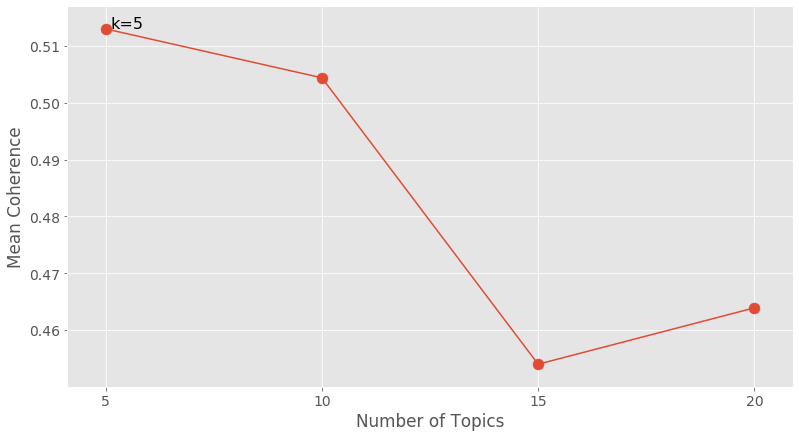

In [16]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 10

In [17]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 10))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.4500
K=10: Coherence=0.4353
K=15: Coherence=0.4230
K=20: Coherence=0.4341


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


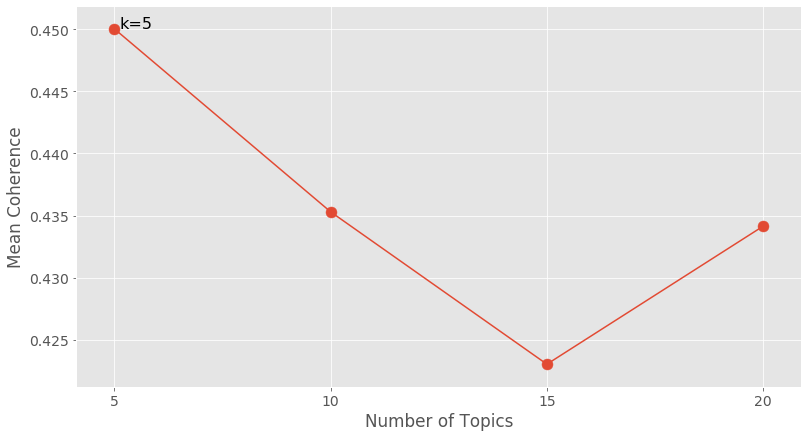

In [18]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 15 

In [19]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 15))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

K=05: Coherence=0.4026
K=10: Coherence=0.3760
K=15: Coherence=0.3687
K=20: Coherence=0.3748


/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


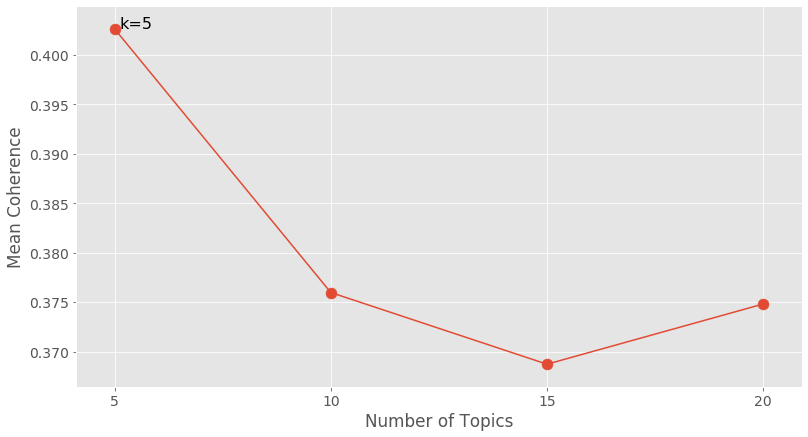

In [20]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

# 20

In [21]:
from itertools import combinations

k_values = []
coherences = []

for (k, W, H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    
    for topic_index in range(k):
        term_rankings.append(get_descriptor(terms, H, topic_index, 20))
    
    # Now calculate the coherence based on our Word2vec model
    k_values.append(k)
    coherences.append(calculate_coherence(w2v_model, term_rankings))
    
    print("K=%02d: Coherence=%.4f" % (k, coherences[-1]))
    # print(f'{coherences[-1]:.4f}')

/home/gean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
  


K=05: Coherence=0.3440
K=10: Coherence=0.3434
K=15: Coherence=0.3381
K=20: Coherence=0.3411


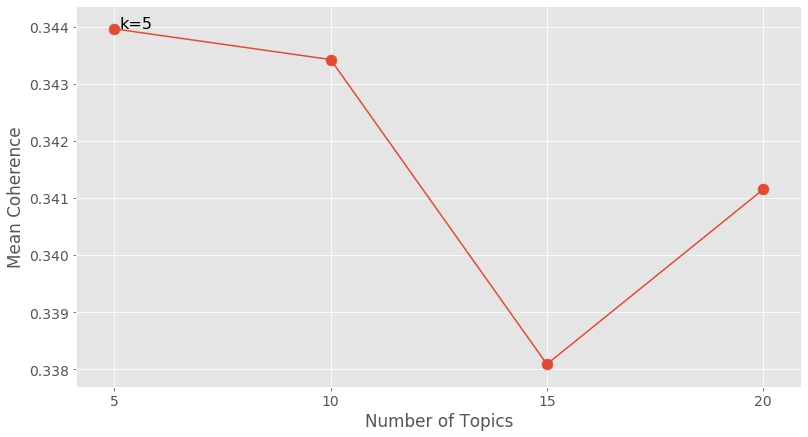

In [22]:
fig = plt.figure(figsize=(13,7))

# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")

# add the points
plt.scatter( k_values, coherences, s=120)


# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate( "k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)

# show the plot
plt.show()

### Examine the Final  Model

The plot above suggests that the most appropriate value for the number of topics is *k=8*.

In [23]:
k = 5 # best_k

# get the model that we generated earlier.
W = topic_models[0][1]
H = topic_models[0][2]

Display the topic descriptors for this model:

In [24]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, mulher, internacional, mulheres
Topic 02: mulher, compromissos, declaracao, assinaram, aceitou
Topic 03: marco, mulheres, carbonizadas, trancadas, tecelagem
Topic 04: lindo, sisters, avancarem, cenas, fechamos
Topic 05: god, woman, fazendo, continuar, vamos


In [25]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, mulher, internacional, mulheres, hoje, lula, marco, mae, parabens
Topic 02: mulher, compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu
Topic 03: marco, mulheres, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, morreram, aproximadamente
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, sabe, inspira, video
Topic 05: god, woman, fazendo, continuar, vamos, historia, mulheres, hoje, luta, queria


In [26]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, mulher, internacional, mulheres, hoje, lula, marco, mae, parabens, fachin, especial, ser, luta, mundo
Topic 02: mulher, compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, defesa, bolsonaro
Topic 03: marco, mulheres, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, morreram, aproximadamente, york, greve, fabrica, nova, onde
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, sabe, inspira, video, juntas, outras, marco, mulher, lula
Topic 05: god, woman, fazendo, continuar, vamos, historia, mulheres, hoje, luta, queria, mundo, dizer, feliz, dia, lutaram


In [27]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: feliz, dia, mulher, internacional, mulheres, hoje, lula, marco, mae, parabens, fachin, especial, ser, luta, mundo, respeito, dias, afinal, boca, povo
Topic 02: mulher, compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, defesa, bolsonaro, governo, direitos, brasil, internacional, dia
Topic 03: marco, mulheres, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, morreram, aproximadamente, york, greve, fabrica, nova, onde, homenagem, dia, bom, lembrar, sempre
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, sabe, inspira, video, juntas, outras, marco, mulher, lula, vai, lembro, milagre, internacional, mundo
Topic 05: god, woman, fazendo, continuar, vamos, historia, mulheres, hoje, luta, queria, mundo, dizer, feliz, dia, lutaram, fortes, melhor, lutam, parabens, tudo


# 10

In [28]:
k = 10 # best_k

# get the model that we generated earlier.
W = topic_models[1][1]
H = topic_models[1][2]

In [29]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, lula, marco
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam
Topic 04: lindo, sisters, avancarem, cenas, fechamos
Topic 05: feliz, dia, mulher, mulheres, woman
Topic 06: god, woman, fazendo, continuar, vamos
Topic 07: mulheres, luta, vida, mundo, dia
Topic 08: marco, vai, power, tapa, uns
Topic 09: estudio, executado, pensado, bernardes, narrativa
Topic 10: mae, fachin, boca, afinal, povo


In [30]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, lula, marco, hoje, parabens, especial, nordestina, ciro
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, video
Topic 05: feliz, dia, mulher, mulheres, woman, god, sangue, guerreiras, incriveis, apenas
Topic 06: god, woman, fazendo, continuar, vamos, historia, queria, dizer, lutaram, dia
Topic 07: mulheres, luta, vida, mundo, dia, parabens, momento, hoje, primeira, vacina
Topic 08: marco, vai, power, tapa, uns, girl, socialista, levar, vem, milagre
Topic 09: estudio, executado, pensado, bernardes, narrativa, saindo, correndo, fatima, manter, cara
Topic 10: mae, fachin, boca, afinal, povo, fez, porque, inteiro, pais, lembrar


In [31]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, lula, marco, hoje, parabens, especial, nordestina, ciro, gomes, ser, homenagem, mensagem, acao
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, bolsonaro, defesa, governo
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram, greve, fabrica, nova, mulheres, onde
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, video, juntas, outras, marco, mulher, lembro
Topic 05: feliz, dia, mulher, mulheres, woman, god, sangue, guerreiras, incriveis, apenas, fodas, ces, respeito, fortes, vcs
Topic 06: god, woman, fazendo, continuar, vamos, historia, queria, dizer, lutaram, dia, melhor, lutam, comemorar, tudo, ariana
Topic 07: mulheres, luta, vida, mundo, dia, parabens, momento, hoje, primeira, vacina, sendo, empoderamento, presidenta, lembra, ciclo
Topic 08: marco, vai, power, tapa, uns, girl,

In [32]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, lula, marco, hoje, parabens, especial, nordestina, ciro, gomes, ser, homenagem, mensagem, acao, romantico, mudaram, politico, aborto, sobre
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, bolsonaro, defesa, governo, direitos, brasil, mulher, internacional, dia
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram, greve, fabrica, nova, mulheres, onde, homenagem, dia, bom, lembrar, sempre
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, video, juntas, outras, marco, mulher, lembro, lula, levanta, insulta, diz, politica
Topic 05: feliz, dia, mulher, mulheres, woman, god, sangue, guerreiras, incriveis, apenas, fodas, ces, respeito, fortes, vcs, deseja, gigante, afasta, seguidoras, distancia
Topic 06: god, woman, fazendo, continuar, vamos, historia, queria, dizer, lutaram, dia, mel

# 15

In [33]:
k = 15 # best_k

# get the model that we generated earlier.
W = topic_models[2][1]
H = topic_models[2][2]

In [34]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, hoje, homenagem
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam
Topic 04: lindo, sisters, avancarem, cenas, fechamos
Topic 05: feliz, dia, mulher, sangue, god
Topic 06: god, woman, fazendo, continuar, historia
Topic 07: mulheres, dia, parabens, incriveis, dias
Topic 08: power, tapa, uns, girl, socialista
Topic 09: estudio, executado, pensado, bernardes, narrativa
Topic 10: mae, fachin, boca, afinal, povo
Topic 11: luta, vida, primeira, vacina, ciclo
Topic 12: mundo, milagre, vai, discurso, comecar
Topic 13: marco, lula, dia, respeito, politico
Topic 14: amor, hoje, duas, assusta, desrespeitosas
Topic 15: nada, agregar, festejar, celebrar, melhor


In [35]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, hoje, homenagem, especial, parabens, nordestina, mensagem, acao
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, juntas
Topic 05: feliz, dia, mulher, sangue, god, woman, gigante, afasta, distancia, amor
Topic 06: god, woman, fazendo, continuar, historia, vamos, queria, dizer, lutaram, melhor
Topic 07: mulheres, dia, parabens, incriveis, dias, fortes, hoje, respeito, woman, god
Topic 08: power, tapa, uns, girl, socialista, levar, vem, vai, marco, camisa
Topic 09: estudio, executado, pensado, bernardes, narrativa, saindo, correndo, manter, cara, fatima
Topic 10: mae, fachin, boca, afinal, povo, fez, porque, inteiro, pais, lembrar
Topic 11: luta, vida, primeira, vacina, ciclo, interrompido, destrui

In [36]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, hoje, homenagem, especial, parabens, nordestina, mensagem, acao, mudaram, gomes, vagina, pessoas, feminismo
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, bolsonaro, defesa, governo
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram, greve, fabrica, nova, onde, mulheres
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, juntas, video, outras, marco, mulher, lembro
Topic 05: feliz, dia, mulher, sangue, god, woman, gigante, afasta, distancia, amor, guerreiras, corajosas, perfeicao, sensiveis, babys
Topic 06: god, woman, fazendo, continuar, historia, vamos, queria, dizer, lutaram, melhor, lutam, dia, comemorar, ariana, tudo
Topic 07: mulheres, dia, parabens, incriveis, dias, fortes, hoje, respeito, woman, god, mundo, especial, lindas, guerreiras, lutam
Topic 08: power, tapa, uns

In [37]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, hoje, homenagem, especial, parabens, nordestina, mensagem, acao, mudaram, gomes, vagina, pessoas, feminismo, ciro, sobre, aborto, chamou, fez
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, bolsonaro, defesa, governo, direitos, brasil, mulher, internacional, dia
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram, greve, fabrica, nova, onde, mulheres, homenagem, dia, bom, lembrar, sempre
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, juntas, video, outras, marco, mulher, lembro, levanta, nordestina, insulta, diz, politica
Topic 05: feliz, dia, mulher, sangue, god, woman, gigante, afasta, distancia, amor, guerreiras, corajosas, perfeicao, sensiveis, babys, doces, contem, complexidade, ces, mulherada
Topic 06: god, woman, fazendo, continuar, historia, vamos, queria, dizer, lu

# 20

In [38]:
k = 20 # best_k

# get the model that we generated earlier.
W = topic_models[3][1]
H = topic_models[3][2]

In [39]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 5)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, nordestina, mensagem
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam
Topic 04: lindo, sisters, avancarem, cenas, fechamos
Topic 05: feliz, dia, mulher, sangue, god
Topic 06: god, woman, fazendo, continuar, historia
Topic 07: mulheres, dia, parabens, incriveis, dias
Topic 08: power, tapa, uns, girl, socialista
Topic 09: estudio, executado, pensado, bernardes, narrativa
Topic 10: mae, fachin, boca, afinal, povo
Topic 11: luta, vida, vacina, ciclo, interrompido
Topic 12: mundo, milagre, vai, discurso, comecar
Topic 13: marco, lula, dia, apenas, respeito
Topic 14: amor, assusta, desrespeitosas, brincadeiras, posicionar
Topic 15: nada, agregar, festejar, celebrar, melhor
Topic 16: ainda, acredite, ser, discutir, visto
Topic 17: ciro, aborto, gomes, chamou, dilma
Topic 18: hoje, dia, melhor, tudo, especial
Topic 19: voz, dulce, rosalina, pioneirismo, pioneira
Topic 20: dona,

In [40]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 10)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, nordestina, mensagem, mudaram, vagina, pessoas, feminismo, parabens
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, juntas
Topic 05: feliz, dia, mulher, sangue, god, woman, guerreiras, gigante, afasta, distancia
Topic 06: god, woman, fazendo, continuar, historia, vamos, queria, dizer, lutaram, comemorar
Topic 07: mulheres, dia, parabens, incriveis, dias, woman, god, vida, respeito, mundo
Topic 08: power, tapa, uns, girl, socialista, levar, vem, vai, marco, camisa
Topic 09: estudio, executado, pensado, bernardes, narrativa, saindo, correndo, manter, cara, programa
Topic 10: mae, fachin, boca, afinal, povo, fez, inteiro, porque, pais, lembrar
Topic 11: luta, vida, vacina, ciclo, interrompido, des

In [41]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 15)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, nordestina, mensagem, mudaram, vagina, pessoas, feminismo, parabens, homenagem, deu, continuacao, presente, show
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, bolsonaro, defesa, governo
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram, greve, fabrica, nova, onde, mulheres
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, juntas, video, outras, marco, mulher, lembro
Topic 05: feliz, dia, mulher, sangue, god, woman, guerreiras, gigante, afasta, distancia, fortes, corajosas, medo, mundo, lutar
Topic 06: god, woman, fazendo, continuar, historia, vamos, queria, dizer, lutaram, comemorar, ariana, lutam, bom, grande, lutando
Topic 07: mulheres, dia, parabens, incriveis, dias, woman, god, vida, respeito, mundo, guerreiras, maravilhosas, contra, vcs, violencia
Topic 08: power, tap

In [42]:
for topic_index in range(k):
    descriptor = get_descriptor( terms, H, topic_index, 20)
    str_descriptor = ", ".join( descriptor )
    print("Topic %02d: %s" % ( topic_index+1, str_descriptor ) )

Topic 01: internacional, mulher, dia, nordestina, mensagem, mudaram, vagina, pessoas, feminismo, parabens, homenagem, deu, continuacao, presente, show, veio, miranda, mostrou, sobre, carmen
Topic 02: compromissos, declaracao, assinaram, aceitou, assinar, assume, paises, humanos, onu, conselho, vergonha, saude, bolsonaro, defesa, governo, direitos, brasil, mulher, internacional, dia
Topic 03: marco, carbonizadas, trancadas, tecelagem, trabalhavam, declarou, estarem, aproximadamente, york, morreram, greve, fabrica, nova, onde, mulheres, homenagem, dia, bom, lembrar, sempre
Topic 04: lindo, sisters, avancarem, cenas, fechamos, apoiando, valor, inspira, sabe, juntas, video, outras, marco, mulher, lembro, levanta, nordestina, amo, insulta, diz
Topic 05: feliz, dia, mulher, sangue, god, woman, guerreiras, gigante, afasta, distancia, fortes, corajosas, medo, mundo, lutar, amor, deseja, respeito, seguidoras, independentes
Topic 06: god, woman, fazendo, continuar, historia, vamos, queria, dizer